In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random, pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
def train_validate_evaluate(classifier, dataset, feature):
    if feature == 'bow':
        item = ''
    elif feature == 'bool-bow':
        item = 'bool-'
    else:
        item = 'lexicon'
    path = './data/SA/' + dataset + '/' + item + 'labeled.npy'
    data = np.transpose(np.load(path))
    X = data[:,:-1]
    y = data[:,-1]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, random_state=15)
    if classifier == 'NB':
        clf = GaussianNB()
    elif classifier == 'LR':
        clf = LogisticRegression(random_state=0)
    elif classifier == 'DT':
        clf = DecisionTreeClassifier(random_state=0)
    elif classifier == 'RF':
        clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    metrics_data = {'dataset': [dataset], 'classifier': [classifier], 'model':[feature],
        'accuracy': [accuracy], 'precision':[precision], 'recall':[recall], 'f1_score': [f1_score]}
    df = pd.DataFrame(data = metrics_data)
    df.index = [dataset + ' ' + classifier + ' ' + feature]
    return df

In [3]:
classifiers = ['NB', 'LR','DT', 'RF']
datasets = ['books', 'dvd', 'electronics', 'kitchen', 'all']
features = ['bow', 'bool-bow']

In [ ]:
df = pd.DataFrame()
for classifier in classifiers:
    for dataset in datasets:
        for feature in features:
            df = pd.concat([df, train_validate_evaluate(classifier, dataset, feature)], axis=0)

In [ ]:
df.groupby('classifier').mean().plot.bar(figsize=(12,8), rot=48)
plt.title('Comparación de clasificadores', fontsize=20)
plt.xlabel('Clasificador', fontsize=15)
plt.ylabel('Porcentaje', fontsize=15)
plt.grid()
plt.savefig('./results/classifier_comparison.png')

In [ ]:
df.groupby('model').mean().plot.bar(figsize=(12,8), rot=48)
plt.title('Comparación de modelos', fontsize=20)
plt.xlabel('Modelo', fontsize=15)
plt.ylabel('Porcentaje', fontsize=15)
plt.grid()
plt.savefig('./results/model_comparison.png')

In [ ]:
df.groupby('dataset').mean().plot.bar(figsize=(12,8), rot=48)
plt.title('Comparación de datasets', fontsize=20)
plt.xlabel('Clasificador', fontsize=15)
plt.ylabel('Porcentaje', fontsize=15)
plt.grid()
plt.savefig('./results/datasets_comparison.png')

In [6]:
n_estimators = np.sort(random.sample(range(1, 1000),50))
parameters = {
    'n_estimators': n_estimators,
    'max_features': ('auto', 'sqrt', 'log2'),
}
scores = ['precision', 'recall']

In [11]:
def test_rf_hyperparameters(dataset, feature):
    if feature == 'bow':
        item = ''
    elif feature == 'bool-bow':
        item = 'bool-'
    else:
        item = 'lexicon'
    path = './data/SA/' + dataset + '/' + item + 'labeled.npy'
    data = np.transpose(np.load(path))
    X = data[:,:-1]
    y = data[:,-1]
    df = pd.DataFrame()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, random_state=15)
    clfs = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        clf = GridSearchCV(RandomForestClassifier(), parameters, scoring='%s_macro' % score, n_jobs=9)
        clf.fit(X_train, y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_val, clf.predict(X_val)
        print(classification_report(y_true, y_pred))
        print()
        clfs.append(clf)
    return clfs

In [12]:
clfs_all_b = test_rf_hyperparameters('all', 'bool-bow')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_features': 'log2', 'n_estimators': 531}

Grid scores on development set:

0.759 (+/-0.047) for {'max_features': 'auto', 'n_estimators': 43}
0.781 (+/-0.053) for {'max_features': 'auto', 'n_estimators': 54}
0.772 (+/-0.029) for {'max_features': 'auto', 'n_estimators': 73}
0.774 (+/-0.060) for {'max_features': 'auto', 'n_estimators': 79}
0.774 (+/-0.068) for {'max_features': 'auto', 'n_estimators': 105}
0.785 (+/-0.037) for {'max_features': 'auto', 'n_estimators': 119}
0.788 (+/-0.056) for {'max_features': 'auto', 'n_estimators': 138}
0.787 (+/-0.048) for {'max_features': 'auto', 'n_estimators': 150}
0.789 (+/-0.060) for {'max_features': 'auto', 'n_estimators': 190}
0.787 (+/-0.051) for {'max_features': 'auto', 'n_estimators': 230}
0.788 (+/-0.059) for {'max_features': 'auto', 'n_estimators': 234}
0.787 (+/-0.065) for {'max_features': 'auto', 'n_estimators': 235}
0.788 (+/-0.056) for {'max_featu

              precision    recall  f1-score   support

       False       0.85      0.75      0.80      3209
        True       0.78      0.86      0.82      3191

    accuracy                           0.81      6400
   macro avg       0.81      0.81      0.81      6400
weighted avg       0.81      0.81      0.81      6400


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_features': 'auto', 'n_estimators': 577}

Grid scores on development set:

0.762 (+/-0.092) for {'max_features': 'auto', 'n_estimators': 43}
0.759 (+/-0.057) for {'max_features': 'auto', 'n_estimators': 54}
0.779 (+/-0.050) for {'max_features': 'auto', 'n_estimators': 73}
0.777 (+/-0.071) for {'max_features': 'auto', 'n_estimators': 79}
0.783 (+/-0.040) for {'max_features': 'auto', 'n_estimators': 105}
0.787 (+/-0.060) for {'max_features': 'auto', 'n_estimators': 119}
0.782 (+/-0.058) for {'max_features': 'auto', 'n_estimators': 138}
0.781 (+/-0.051) for {'max_features': 'aut

              precision    recall  f1-score   support

       False       0.83      0.78      0.80      3209
        True       0.79      0.84      0.81      3191

    accuracy                           0.81      6400
   macro avg       0.81      0.81      0.81      6400
weighted avg       0.81      0.81      0.81      6400




In [13]:
clfs_all = test_rf_hyperparameters('all', 'bow')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_features': 'log2', 'n_estimators': 944}

Grid scores on development set:

0.750 (+/-0.079) for {'max_features': 'auto', 'n_estimators': 43}
0.766 (+/-0.054) for {'max_features': 'auto', 'n_estimators': 54}
0.770 (+/-0.062) for {'max_features': 'auto', 'n_estimators': 73}
0.770 (+/-0.058) for {'max_features': 'auto', 'n_estimators': 79}
0.780 (+/-0.037) for {'max_features': 'auto', 'n_estimators': 105}
0.771 (+/-0.051) for {'max_features': 'auto', 'n_estimators': 119}
0.792 (+/-0.050) for {'max_features': 'auto', 'n_estimators': 138}
0.778 (+/-0.044) for {'max_features': 'auto', 'n_estimators': 150}
0.780 (+/-0.046) for {'max_features': 'auto', 'n_estimators': 190}
0.793 (+/-0.056) for {'max_features': 'auto', 'n_estimators': 230}
0.786 (+/-0.065) for {'max_features': 'auto', 'n_estimators': 234}
0.784 (+/-0.066) for {'max_features': 'auto', 'n_estimators': 235}
0.793 (+/-0.046) for {'max_featu

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      3209
           1       0.79      0.86      0.82      3191

    accuracy                           0.82      6400
   macro avg       0.82      0.82      0.82      6400
weighted avg       0.82      0.82      0.82      6400


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_features': 'log2', 'n_estimators': 944}

Grid scores on development set:

0.754 (+/-0.025) for {'max_features': 'auto', 'n_estimators': 43}
0.762 (+/-0.082) for {'max_features': 'auto', 'n_estimators': 54}
0.771 (+/-0.072) for {'max_features': 'auto', 'n_estimators': 73}
0.763 (+/-0.039) for {'max_features': 'auto', 'n_estimators': 79}
0.767 (+/-0.033) for {'max_features': 'auto', 'n_estimators': 105}
0.785 (+/-0.055) for {'max_features': 'auto', 'n_estimators': 119}
0.782 (+/-0.065) for {'max_features': 'auto', 'n_estimators': 138}
0.792 (+/-0.064) for {'max_features': 'aut

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      3209
           1       0.76      0.87      0.81      3191

    accuracy                           0.80      6400
   macro avg       0.81      0.80      0.80      6400
weighted avg       0.81      0.80      0.80      6400




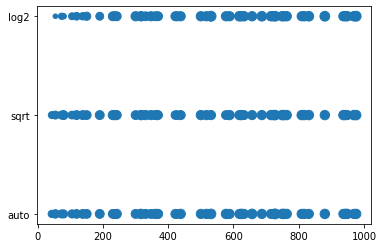

In [14]:
clf = clfs_all_b[0]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

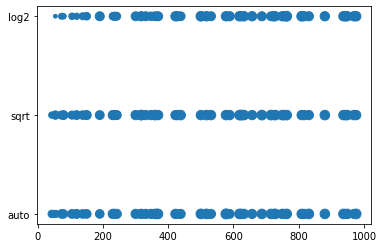

In [15]:
clf = clfs_all_b[1]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

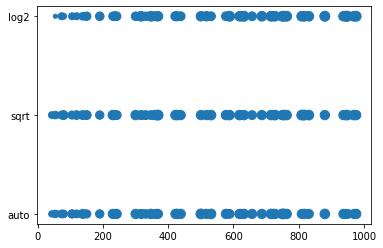

In [16]:
clf = clfs_all[0]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

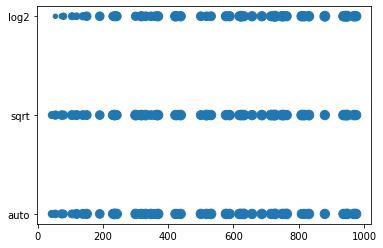

In [17]:
clf = clfs_all[1]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

In [22]:
pickle.dump(clfs_all, open('./resources/SA/clfs_all.pkl', ''))

TypeError: write() argument must be str, not bytes